# Création du dataset avec les variables descriptives du quartier

L'objectif de ce notebook est de créer le dataset de travail i.e., le dataset des biens immobiliers avec les variables descriptives du quartier. 

- **Etape 1** : Nettoyage de la base de données DVF géolocalisés
- **Etape 2** : Réalisation de la base de données des équipements parisiens géolocalisés
    - Les équipements parisiens géolocalisés utilisables à partir de la base de donnée BPE
    - les espaces verts parisiens géolocalisés
    - les stations de métros géolocalisés
    - les monuments géolocalisés
- **Etape 3** : Lier les données des équipements aux biens immobiliers, i.e. **définitions du quartier**
    - création du dataset de travail
    - (la computation de cette dernière étape est longue)

### Import des modules nécessaires

In [1]:
import pandas as pd
import numpy as np 
import math

#to compute the distance between the house and services (bakery, supermarket, parks...)
from numpy import cos, sin, arcsin, sqrt
from math import radians
from pyproj import Transformer

#geopandas to open the parc data file
import geopandas as gpd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Nettoyage de la base de donnée DVF

### Découverte du dataset

In [2]:
# Source du dataset original : https://www.data.gouv.fr/fr/datasets/r/316795eb-a3fa-465d-b058-38ef8579da11
# dans le cadre de ce projet, le dataset utilisé est celui de l'année 2020 et du département 75
df_biens = pd.read_csv('data/75_20.csv',sep=',', low_memory=False)
df_biens


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1417749,2020-01-02,1,Vente,268800.0,14.0,NaN,RUE DE L ARCADE,0411,75008.0,...,Appartement,24.0,1.0,NaN,NaN,NaN,NaN,NaN,2.323937,48.871607
1,2020-1417750,2020-01-06,1,Vente,878378.0,9.0,NaN,BD DE LA MADELEINE,5888,75001.0,...,Appartement,66.0,2.0,NaN,NaN,NaN,NaN,NaN,2.326882,48.869331
2,2020-1417750,2020-01-06,1,Vente,878378.0,9.0,NaN,BD DE LA MADELEINE,5888,75001.0,...,Local industriel. commercial ou assimilé,43.0,0.0,NaN,NaN,NaN,NaN,NaN,2.326882,48.869331
3,2020-1417751,2020-01-10,1,Vente,680000.0,10.0,NaN,RUE DU BOURG L ABBE,1200,75003.0,...,Appartement,51.0,2.0,NaN,NaN,NaN,NaN,NaN,2.351965,48.864157
4,2020-1417752,2020-01-03,1,Vente,852000.0,24.0,NaN,RUE DE SAINTONGE,8716,75003.0,...,Appartement,12.0,1.0,NaN,NaN,NaN,NaN,NaN,2.363196,48.862017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54544,2020-1455980,2020-12-16,1,Vente,1937500.0,24.0,NaN,RUE CHANOINESSE,1748,75004.0,...,Appartement,22.0,1.0,S,sols,NaN,NaN,447.0,2.350486,48.854301
54545,2020-1455980,2020-12-16,1,Vente,1937500.0,24.0,NaN,RUE CHANOINESSE,1748,75004.0,...,Local industriel. commercial ou assimilé,100.0,0.0,S,sols,NaN,NaN,447.0,2.350486,48.854301
54546,2020-1455980,2020-12-16,1,Vente,1937500.0,24.0,NaN,RUE CHANOINESSE,1748,75004.0,...,Dépendance,NaN,0.0,S,sols,NaN,NaN,447.0,2.350486,48.854301
54547,2020-1455980,2020-12-16,1,Vente,1937500.0,24.0,NaN,RUE CHANOINESSE,1748,75004.0,...,Appartement,87.0,4.0,S,sols,NaN,NaN,447.0,2.350486,48.854301


In [3]:
df_biens.columns

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

In [4]:
for e in df_biens.columns:
    print(df_biens[e].value_counts())

2020-1422930    292
2020-1418077    291
2020-1432914     87
2020-1424030     87
2020-1426516     82
               ... 
2020-1431773      1
2020-1431772      1
2020-1431771      1
2020-1431770      1
2020-1455981      1
Name: id_mutation, Length: 38233, dtype: int64
2020-12-10    715
2020-02-07    645
2020-12-17    582
2020-12-18    570
2020-06-30    560
             ... 
2020-08-22      1
2020-10-24      1
2020-02-23      1
2020-10-18      1
2020-10-25      1
Name: date_mutation, Length: 304, dtype: int64
1    54003
2      498
3       33
6        7
4        5
5        3
Name: numero_disposition, dtype: int64
Vente                                 52884
Vente en l'état futur d'achèvement      982
Echange                                 503
Adjudication                            159
Expropriation                            17
Vente terrain à bâtir                     4
Name: nature_mutation, dtype: int64
300000.0      351
400000.0      292
93141336.0    292
13390000.0    291
30000.0    

In [ ]:
df_biens.info()

### Nettoyage du dataset 

Il y a beaucoup de colonnes inutiles et/ou inexploitables : 
- id_mutation : identifiant non stable
- numero_disposition 
- adresse_numero
- adresse_suffixe
- adresse_code_voie : Code FANTOIR de la voie
- adresse_nom_voie 
- code_commune
- nom_commune : Nom de la commune (accentué)
- ancien_code_commune : Ancien code commune INSEE (si différent lors de la mutation)
- ancien_nom_commune
- code_departement
- id_parcelle
- ancien_id_parcelle
- numero_volume
- les colonnes *lots*
- les colonnes *nature_culture*
- surface_terrain

In [5]:
df_biens.drop(columns=['id_mutation', 'numero_disposition','adresse_numero','adresse_suffixe','adresse_code_voie',
    'adresse_nom_voie','code_commune','nom_commune', 'ancien_code_commune','ancien_nom_commune','code_departement',
    'id_parcelle','ancien_id_parcelle','numero_volume','lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 
    'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez','lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
    'lot5_surface_carrez','nombre_lots', 'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain'],inplace=True)

Dans ce projet, nous analyserons seulement les **ventes** d'**appartements**.

In [6]:
df_appart=df_biens.loc[(df_biens['type_local']=='Appartement')& (df_biens['nature_mutation']=='Vente')].copy()
df_appart.reset_index(inplace=True, drop=True)
df_appart.drop(columns=['type_local','nature_mutation','code_type_local'],inplace=True)
df_appart

,date_mutation,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,longitude,latitude
0,2020-01-02,268800.0,75008.0,24.0,1.0,2.323937,48.871607
1,2020-01-06,878378.0,75001.0,66.0,2.0,2.326882,48.869331
2,2020-01-10,680000.0,75003.0,51.0,2.0,2.351965,48.864157
3,2020-01-03,852000.0,75003.0,12.0,1.0,2.363196,48.862017
4,2020-01-03,852000.0,75003.0,12.0,1.0,2.363196,48.862017
...,...,...,...,...,...,...,...
34237,2020-12-16,1937500.0,75004.0,37.0,2.0,2.350486,48.854301
34238,2020-12-16,1937500.0,75004.0,46.0,2.0,2.350486,48.854301
34239,2020-12-16,1937500.0,75004.0,32.0,2.0,2.350486,48.854301
34240,2020-12-16,1937500.0,75004.0,22.0,1.0,2.350486,48.854301


#### Correction du type de données


In [7]:
df_appart['code_postal']=df_appart['code_postal'].astype(int)
df_appart['nombre_pieces_principales']=df_appart['nombre_pieces_principales'].astype(int)
df_appart

,date_mutation,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,longitude,latitude
0,2020-01-02,268800.0,75008,24.0,1,2.323937,48.871607
1,2020-01-06,878378.0,75001,66.0,2,2.326882,48.869331
2,2020-01-10,680000.0,75003,51.0,2,2.351965,48.864157
3,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017
4,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017
...,...,...,...,...,...,...,...
34237,2020-12-16,1937500.0,75004,37.0,2,2.350486,48.854301
34238,2020-12-16,1937500.0,75004,46.0,2,2.350486,48.854301
34239,2020-12-16,1937500.0,75004,32.0,2,2.350486,48.854301
34240,2020-12-16,1937500.0,75004,22.0,1,2.350486,48.854301


Nous obtenons notre dataset final i.e., celui des **ventes d'appartement à Paris en 2020** avec pour comme features :
- la date de vente du bien, 
- le prix, le nombre de pièce, 
- la superficie en m^2, 
- le code postal 
- et la géolocalisation (latitude et longitude)

## 2. Création de la base de données équipements

### a) A partir de la base des données BPE

#### Réccupération de la base des données

In [8]:
#base permanente des équipements 
# source INSEE : https://www.insee.fr/fr/statistiques/3568638?sommaire=3568656&q=bpe
# Télécharger aussi l'explication des codes : Dictionnaire des variables/Liste des variables de la table ensemble
# réaliser avec celle de 2020
df_equip=pd.read_csv('data/bpe20_ensemble_xy.csv',sep=';')
df_equip

C:\Users\natac\AppData\Local\Temp\ipykernel_1936\1262821734.py:6: DtypeWarning: Columns (0,2,4,5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_equip=pd.read_csv('data/bpe20_ensemble_xy.csv',sep=';')


,AAV2020,AN,BV2012,DCIRIS,DEP,DEPCOM,EPCI,LABEL,LAMBERT_X,LAMBERT_Y,QUALITE_XY,REG,TYPEQU,UU2020
0,524,2020,1093,01001,1,1001,200069193.0,X,848167.97,6563141.11,Bonne,84,A404,NaN
1,524,2020,1093,01001,1,1001,200069193.0,X,847950.00,6566550.00,Mauvaise,84,B202,NaN
2,524,2020,1093,01001,1,1001,200069193.0,X,848138.54,6563088.31,Bonne,84,B203,NaN
3,524,2020,1093,01001,1,1001,200069193.0,X,848350.00,6563150.00,Mauvaise,84,A401,NaN
4,524,2020,1093,01001,1,1001,200069193.0,X,848050.00,6562850.00,Mauvaise,84,A504,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706348,9F1,2020,NaN,97617_XXXX,976,97617,200059871.0,X,NaN,NaN,Non géolocalisé,6,A504,9F304
2706349,9F1,2020,NaN,97617_XXXX,976,97617,200059871.0,X,NaN,NaN,Non géolocalisé,6,B202,9F304
2706350,9F1,2020,NaN,97617_XXXX,976,97617,200059871.0,X,NaN,NaN,Non géolocalisé,6,B202,9F304
2706351,9F1,2020,NaN,97617_XXXX,976,97617,200059871.0,X,NaN,NaN,Non géolocalisé,6,B202,9F304


#### Nettoyage de la base de données
- Filtrage de données : selection des données de Paris (75)
- Réccupération des variables intéressantes/utilisables
- Encodage des colonnes

In [9]:
#selection des données de Paris uniquement (notre périmètre d'étude)
df_equip=df_equip.loc[df_equip['DEP']==75].copy()
df_equip.reset_index(inplace=True,drop=True) #mise à jour de l'index
# Ajout de la colonne "code postal"
code=df_equip['DEPCOM']-100
df_equip.insert(0,'code_postal',code.tolist())

#suppression des colonnes inutiles
df_equip.drop(columns=['AAV2020','BV2012','DEP','DCIRIS','DEPCOM','AN','EPCI','LABEL','REG','UU2020'],inplace=True)
df_equip

,code_postal,LAMBERT_X,LAMBERT_Y,QUALITE_XY,TYPEQU
0,75001,651292.20,6862868.80,Bonne,B302
1,75001,652113.78,6862575.10,Bonne,B301
2,75001,650882.30,6863051.90,Bonne,B302
3,75001,651941.70,6862560.80,Bonne,A504
4,75001,652032.31,6862171.18,Bonne,B301
...,...,...,...,...,...
145024,75020,654995.50,6863063.00,Bonne,F103
145025,75020,656855.00,6863955.00,Bonne,F111
145026,75020,654447.60,6863671.00,Bonne,F114
145027,75020,656859.30,6862568.00,Bonne,F113


On arrive à un table de données plus épurés avec seulement les équipements de Paris. 
Vérifions maintenant la qualité des données restantes.

In [10]:
pd.set_option('display.max_rows', 8)
df_equip['QUALITE_XY'].value_counts()

Bonne              142866
Acceptable           1350
Mauvaise              744
Non géolocalisé        69
Name: QUALITE_XY, dtype: int64

In [11]:
#suppression des données non géolocalisées => inutilisables
pas_loc_idx=df_equip.index[df_equip['QUALITE_XY']=='Non géolocalisé'].tolist()
df_equip.drop(index=pas_loc_idx,inplace=True)

#### Traduction de l'encodage du type d'équipement

In [12]:
#Création d'une nouvelle colonne Groupe avec l'unique valeur None
df_equip.insert(1, 'Groupe', None)
df_equip

,code_postal,Groupe,LAMBERT_X,LAMBERT_Y,QUALITE_XY,TYPEQU
0,75001,None,651292.20,6862868.8,Bonne,B302
1,75001,None,652113.78,6862575.1,Bonne,B301
2,75001,None,650882.30,6863051.9,Bonne,B302
3,75001,None,651941.70,6862560.8,Bonne,A504
...,...,...,...,...,...,...
145025,75020,None,656855.00,6863955.0,Bonne,F111
145026,75020,None,654447.60,6863671.0,Bonne,F114
145027,75020,None,656859.30,6862568.0,Bonne,F113
145028,75020,None,656868.40,6862363.0,Bonne,F112


##### Focus sur le sport (catégorie F1)

In [13]:
df_sport=df_equip.loc[df_equip['TYPEQU'].str.contains("F1")] # F1-- = installations sportives
pd.set_option('display.max_rows', 19)
df_sport['TYPEQU'].value_counts()

F120    207
F121    181
F112    178
F111    162
F114    125
F101     85
F103     77
F116     59
F102     52
F113     46
F107     46
F106     11
F117     11
F109      8
F119      6
F108      5
F110      2
F104      2
F118      1
Name: TYPEQU, dtype: int64

In [14]:
#suppression des équipements sportifs pas assez représentatifs (trop spécifiques, pas assez nombreux...)

#F102 = boulodrome
index=df_equip.index[df_equip['TYPEQU']=='F102'].tolist()

df_equip.drop(index=index,inplace=True)
df_equip.reset_index(inplace=True,drop=True)

In [15]:
#regroupement des équipements sportifs simmilaires


##salles des sports

#salles spécialisées
salle_idx=df_equip.index[df_equip['TYPEQU']=='F112'].tolist()
#salles de combat
salle_idx+=df_equip.index[df_equip['TYPEQU']=='F114'].tolist()
#salles non spécialisées
salle_idx+=df_equip.index[df_equip['TYPEQU']=='F116'].tolist()
#salles de remise en forme
salle_idx+=df_equip.index[df_equip['TYPEQU']=='F120'].tolist()
#gymnase
salle_idx+=df_equip.index[df_equip['TYPEQU']=='F121'].tolist()

df_equip.loc[salle_idx,'Groupe']='Salle de sport'

##équipements sportifs extérieurs

#Athlétisme
ext_idx=df_equip.index[df_equip['TYPEQU']=='F107'].tolist()
#Tennis
ext_idx+=df_equip.index[df_equip['TYPEQU']=='F103'].tolist()
#terrain de grands jeux
ext_idx+=df_equip.index[df_equip['TYPEQU']=='F113'].tolist()
#skate park
ext_idx+=df_equip.index[df_equip['TYPEQU']=='F117'].tolist()
#Plateaux et terrains de jeux extérieurs
ext_idx+=df_equip.index[df_equip['TYPEQU']=='F111'].tolist()
#Parcours sportif/santé
ext_idx+=df_equip.index[df_equip['TYPEQU']=='F109'].tolist()
#Terrain de golf
ext_idx+=df_equip.index[df_equip['TYPEQU']=='F108'].tolist()

df_equip.loc[ext_idx,'Groupe']='Equipements sportifs extérieurs'

#natation
natation_idx=df_equip.index[df_equip['TYPEQU']=='F101'].tolist()
df_equip.loc[natation_idx,'Groupe']='Piscine'

##### Focus sur la santé (catégorie D)

In [16]:
##médecins (D2--)
df_medecin=df_equip.loc[df_equip['TYPEQU'].str.contains("D2")]
count=df_medecin['TYPEQU'].value_counts()
medecin_idx=count.index.tolist()
print(medecin_idx)

#généraliste
generaliste_idx=df_equip.index[df_equip['TYPEQU']=='D201'].tolist()
medecin_idx.remove('D201')

df_equip.loc[generaliste_idx,'Groupe']='Généraliste'

#medecins spécialistes + autre
specialiste_idx=[]
for e in medecin_idx:
    specialiste_idx+=df_equip.index[df_equip['TYPEQU']==e].tolist()

df_equip.loc[specialiste_idx,'Groupe']='Médecine spécialisée'

    
##pharmacie (D307)
pharmacie_idx=df_equip.index[df_equip['TYPEQU']=='D307'].tolist()
df_equip.loc[pharmacie_idx,'Groupe']='Pharmacie'

#urgences (D107)
hopital_idx=df_equip.index[df_equip['TYPEQU']=='D106'].tolist()
df_equip.loc[hopital_idx,'Groupe']='Urgences'

['D233', 'D243', 'D232', 'D201', 'D221', 'D207', 'D235', 'D237', 'D212', 'D214', 'D208', 'D203', 'D202', 'D231', 'D210', 'D242', 'D206', 'D236', 'D209', 'D240', 'D213', 'D238', 'D211', 'D239']


In [17]:
df_equip

,code_postal,Groupe,LAMBERT_X,LAMBERT_Y,QUALITE_XY,TYPEQU
0,75001,None,651292.20,6862868.80,Bonne,B302
1,75001,None,652113.78,6862575.10,Bonne,B301
2,75001,None,650882.30,6863051.90,Bonne,B302
3,75001,None,651941.70,6862560.80,Bonne,A504
4,75001,None,652032.31,6862171.18,Bonne,B301
...,...,...,...,...,...,...
144903,75020,Equipements sportifs extérieurs,654995.50,6863063.00,Bonne,F103
144904,75020,Equipements sportifs extérieurs,656855.00,6863955.00,Bonne,F111
144905,75020,Salle de sport,654447.60,6863671.00,Bonne,F114
144906,75020,Equipements sportifs extérieurs,656859.30,6862568.00,Bonne,F113


##### Focus sur l'enseignement (catégorie C)

In [18]:
#D502 = Crèche
creche_idx=df_equip.index[df_equip['TYPEQU']=='D502'].tolist()
df_equip.loc[creche_idx,'Groupe']='Crèche'

#Maternelle
maternelle_idx=df_equip.index[df_equip['TYPEQU']=='C101'].tolist()
df_equip.loc[maternelle_idx,'Groupe']='Maternelle'

#Primaire
prim_idx=df_equip.index[df_equip['TYPEQU']=='C104'].tolist()
df_equip.loc[prim_idx,'Groupe']='Primaire'

#Collège
college_idx=df_equip.index[df_equip['TYPEQU'].str.contains("C2")].tolist()
df_equip.loc[college_idx,'Groupe']='Collège'

#Lycée
redondant=df_equip.index[df_equip['TYPEQU']=="C305"].tolist()
df_equip.drop(index=redondant,inplace=True)
lycee_idx=df_equip.index[df_equip['TYPEQU'].str.contains("C3")].tolist()
df_equip.loc[lycee_idx,'Groupe']='Lycée'

#Enseignements supérieurs
sup_idx=df_equip.index[df_equip['TYPEQU'].str.contains("C5")].tolist()
sup_idx+=df_equip.index[df_equip['TYPEQU'].str.contains("C4")].tolist()
df_equip.loc[sup_idx,'Groupe']='Enseignement supérieur'

##### Focus sur les divertissements culturelles (catégorie F)

In [19]:
#bowling F119
div_idx=df_equip.index[df_equip['TYPEQU']=='F119'].tolist()

#le reste (cinema, théatre, lieux d'exposition...)
div_idx+=df_equip.index[df_equip['TYPEQU'].str.contains("F3")].tolist()

df_equip.loc[div_idx,'Groupe']='Divertissement Culturelle'

##### Focus sur les services/commerces

In [20]:
#banque
banque_idx=df_equip.index[df_equip['TYPEQU']=='A203'].tolist()
df_equip.loc[banque_idx,'Groupe']='Banque'

#poste
poste_idx=df_equip.index[df_equip['TYPEQU']=='A206'].tolist()
poste_idx+=df_equip.index[df_equip['TYPEQU']=='A207'].tolist()
poste_idx+=df_equip.index[df_equip['TYPEQU']=='A208'].tolist()
df_equip.loc[poste_idx,'Groupe']='Poste'

#Restaurants
resto_idx=df_equip.index[df_equip['TYPEQU']=='A504'].tolist()
df_equip.loc[resto_idx,'Groupe']='Restaurant'

#agence immobilière
immo_idx=df_equip.index[df_equip['TYPEQU']=='A505'].tolist()
df_equip.loc[immo_idx,'Groupe']='Agence immobilière'

##Commerces alimentaires
alim_idx=df_equip.index[df_equip['TYPEQU']=='B101'].tolist()
alim_idx+=df_equip.index[df_equip['TYPEQU']=='B102'].tolist()
alim_idx+=df_equip.index[df_equip['TYPEQU'].str.contains("B2")].tolist()
df_equip.loc[alim_idx,'Groupe']='Commerce alimentaire'

#boulangerie
boul_idx=df_equip.index[df_equip['TYPEQU']=='B203'].tolist()
df_equip.loc[boul_idx,'Groupe']='Boulangerie'

#Commerces (vêtements, chaussures...)
sta_idx=df_equip.index[df_equip['TYPEQU']=='B316'].tolist()
df_equip.drop(index=sta_idx,inplace=True)
commerce_idx=df_equip.index[df_equip['TYPEQU'].str.contains("B3")].tolist()
df_equip.loc[commerce_idx,'Groupe']='Commerce'

In [21]:
pd.set_option('display.max_rows', 20)
df_equip.drop_duplicates(keep = 'first', inplace=True)
df_equip.dropna(axis=0,inplace=True)
df_equip['Groupe'].value_counts()

Commerce                17234
Restaurant              15910
Médecine spécialisée    11502
Agence immobilière       6838
Commerce alimentaire     4273
                        ...  
Lycée                     233
Poste                     202
Collège                   198
Piscine                    85
Urgences                   16
Name: Groupe, Length: 21, dtype: int64

##### Mise en forme finale

In [22]:
#conversion Lambert to latitude/longitude
transformer = Transformer.from_crs('epsg:2154', 'epsg:4326')
df_equip['Latitude'], df_equip['Longitude'] = transformer.transform(df_equip['LAMBERT_X'].tolist(), df_equip['LAMBERT_Y'].tolist())

In [23]:
#suppression des colonnes inutiles
df_equip.drop(columns=['LAMBERT_X','LAMBERT_Y','QUALITE_XY','TYPEQU','code_postal'],inplace=True)
df_equip.reset_index(inplace=True,drop=True)

### b) A partir du dataset *Monuments*

Nous avons crée notre propre dataset *Monuments* car nous souhaitons seulement sélectionner les plus connus. 
Nous avons utiliser le classement du site web (https://www.parisinfo.com/decouvrir-paris/musees-monuments-patrimoine-paris/monuments/les-monuments-parisiens-un-patrimoine-exceptionnel) pour établir une liste de 32 monuments qui nous semblaient les plus connus.
Pour obtenir leur cordonnée GPS, nous avons utiliser le site web (https://www.coordonnees-gps.fr/) qui calcule les cordonnées GPS d'une adresse. 

In [24]:
df_monuments=pd.read_csv('data/monuments_Paris.csv', index_col=0)
df_monuments

,Monuments,Longitude,Latitude
0,Fondation Louis Vuitton,2.263338,48.876650
1,La Tour Eiffel,2.294481,48.858370
2,Arc de Triomphe,2.295037,48.873779
3,Palais de Tokyo,2.296521,48.863990
4,Avenue des Champs-Élysées,2.296879,48.873194
...,...,...,...
27,Passage Brady,2.356524,48.870885
28,Gare du Nord,2.357438,48.881399
29,Institut du monde arabe,2.357493,48.848916
30,Gare de l'Est,2.357913,48.876203


In [25]:
df_monuments.insert(0,'Groupe','Monument')
df_monuments.drop(columns=['Monuments'],inplace=True)
df_monuments

,Groupe,Longitude,Latitude
0,Monument,2.263338,48.876650
1,Monument,2.294481,48.858370
2,Monument,2.295037,48.873779
3,Monument,2.296521,48.863990
4,Monument,2.296879,48.873194
...,...,...,...
27,Monument,2.356524,48.870885
28,Monument,2.357438,48.881399
29,Monument,2.357493,48.848916
30,Monument,2.357913,48.876203


### c) A partir du dataset *Métros*

In [26]:
df_metro=pd.read_csv('data/arrets.csv',sep=';')
df_metro

,ArRId,ArRVersion,ArRCreated,ArRChanged,ArRName,ArRXEpsg2154,ArRYEpsg2154,ArRType,ArRTown,ArRPostalRegion,ArRAccessibility,ArRAudibleSignals,ArRVisualSigns,ArRFareZone,ArRGeopoint
0,22036,1306133-1026746,2014-12-29T02:00:00+01:00,2021-07-22T21:42:25+02:00,Anatole France,647573,6866037,metro,Levallois-Perret,92044,false,true,true,2,"48.892206616666066,2.284981696340319"
1,412355,1024428-45558,2015-02-12T02:00:00+01:00,2021-05-05T20:34:31+02:00,Funiculaire Gare haute,651787,6865263,metro,Paris 18e,75118,true,false,false,1,"48.88557568016991,2.342538863675838"
2,463196,1024434-45558,2019-01-29T02:00:00+01:00,2021-05-05T20:34:31+02:00,Funiculaire Gare haute,651787,6865263,metro,Paris 18e,75118,true,false,false,1,"48.88557568016991,2.342538863675838"
3,463014,1022042-1106201,2019-01-28T02:00:00+01:00,2021-05-05T18:30:02+02:00,Antony,648595,6850714,metro,Antony,92002,true,false,false,2,"48.75448744080988,2.3007698833739174"
4,22114,1022698-44345,2014-12-29T02:00:00+01:00,2021-05-04T21:56:37+02:00,Pigalle,651470,6864898,metro,Paris 18e,75118,false,true,true,1,"48.88226954127823,2.338257976509586"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,463156,1332106-1034811,2019-01-29T02:00:00+01:00,2021-10-04T18:46:51+02:00,Buttes Chaumont,654647,6864444,metro,Paris 19e,75119,false,true,true,1,"48.87842297018344,2.3816329214594845"
779,21987,1332064-1026843,2014-12-29T02:00:00+01:00,2021-10-04T18:26:46+02:00,Avenue Émile Zola,648266,6860999,metro,Paris 15e,75115,false,true,true,1,"48.84695722895351,2.2950459810371466"
780,22136,1328441-44799,2014-12-29T02:00:00+01:00,2021-09-13T19:44:14+02:00,Saint-Germain-des-Prés,651127,6861710,metro,Paris 6e,75106,false,true,true,1,"48.853574562874215,2.3339478107981932"
781,22181,1328278-1035221,2014-12-29T02:00:00+01:00,2021-09-13T17:57:08+02:00,Daumesnil,655679,6860101,metro,Paris 12e,75112,false,true,true,1,"48.83943400710489,2.3961486284893696"


In [27]:
df_metro=df_metro.loc[df_metro['ArRTown'].str.contains(r'^Paris', regex = True)].copy()
df_metro.reset_index(inplace=True)
df_metro

,index,ArRId,ArRVersion,ArRCreated,ArRChanged,ArRName,ArRXEpsg2154,ArRYEpsg2154,ArRType,ArRTown,ArRPostalRegion,ArRAccessibility,ArRAudibleSignals,ArRVisualSigns,ArRFareZone,ArRGeopoint
0,1,412355,1024428-45558,2015-02-12T02:00:00+01:00,2021-05-05T20:34:31+02:00,Funiculaire Gare haute,651787,6865263,metro,Paris 18e,75118,true,false,false,1,"48.88557568016991,2.342538863675838"
1,2,463196,1024434-45558,2019-01-29T02:00:00+01:00,2021-05-05T20:34:31+02:00,Funiculaire Gare haute,651787,6865263,metro,Paris 18e,75118,true,false,false,1,"48.88557568016991,2.342538863675838"
2,4,22114,1022698-44345,2014-12-29T02:00:00+01:00,2021-05-04T21:56:37+02:00,Pigalle,651470,6864898,metro,Paris 18e,75118,false,true,true,1,"48.88226954127823,2.338257976509586"
3,5,22129,1025412-44372,2014-12-29T02:00:00+01:00,2021-05-04T21:56:37+02:00,Place de Clichy,650675,6865068,metro,Paris 18e,75118,false,true,true,1,"48.883737889279665,2.327398345647012"
4,6,22124,1023312-1026851,2014-12-29T02:00:00+01:00,2021-05-04T21:56:37+02:00,Avron,655839,6861458,metro,Paris 20e,75120,false,true,true,1,"48.85164854264895,2.398187556659396"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,778,463156,1332106-1034811,2019-01-29T02:00:00+01:00,2021-10-04T18:46:51+02:00,Buttes Chaumont,654647,6864444,metro,Paris 19e,75119,false,true,true,1,"48.87842297018344,2.3816329214594845"
648,779,21987,1332064-1026843,2014-12-29T02:00:00+01:00,2021-10-04T18:26:46+02:00,Avenue Émile Zola,648266,6860999,metro,Paris 15e,75115,false,true,true,1,"48.84695722895351,2.2950459810371466"
649,780,22136,1328441-44799,2014-12-29T02:00:00+01:00,2021-09-13T19:44:14+02:00,Saint-Germain-des-Prés,651127,6861710,metro,Paris 6e,75106,false,true,true,1,"48.853574562874215,2.3339478107981932"
650,781,22181,1328278-1035221,2014-12-29T02:00:00+01:00,2021-09-13T17:57:08+02:00,Daumesnil,655679,6860101,metro,Paris 12e,75112,false,true,true,1,"48.83943400710489,2.3961486284893696"


In [28]:
df_metro[['Latitude','Longitude']] = df_metro['ArRGeopoint'].str.split(",",expand=True)
df_metro.insert(0,'Groupe','Métro')
df_metro=df_metro[['Groupe','Latitude','Longitude']].copy()
df_metro.drop_duplicates(inplace=True)
df_metro.reset_index(drop=True, inplace=True)
df_metro

,Groupe,Latitude,Longitude
0,Métro,48.88557568016991,2.342538863675838
1,Métro,48.88226954127823,2.338257976509586
2,Métro,48.883737889279665,2.327398345647012
3,Métro,48.85164854264895,2.398187556659396
4,Métro,48.8776953448575,2.3705761028196566
...,...,...,...
587,Métro,48.87842297018344,2.3816329214594845
588,Métro,48.84695722895351,2.2950459810371466
589,Métro,48.853574562874215,2.3339478107981932
590,Métro,48.83943400710489,2.3961486284893696


### d) A partir du dataset *Espaces verts*

Le dataset *Espaces verts* est un fichier shapefile i.e. il contient des informations géométriques concernant chaque ligne (i.e. espaces verts). La lecture de ce fichier ne peut se faire avec  pandas, nous avons besoin d'utiliser géopandas

In [29]:
# source : https://opendata.paris.fr/explore/dataset/espaces_verts/
# il s'agit d'un fichier shapefile => utilisation de géopandas
df_parc=gpd.read_file('data/espaces_verts.shp', encoding='utf-8')
df_parc.head()

,nsq_espace_,nom_ev,type_ev,categorie,adresse_num,adresse_com,adresse_typ,adresse_lib,adresse_cod,poly_area,...,nb_entites,ouvert_ferm,id_division,id_atelier_,ida3d_enb,site_villes,id_eqpt,competence,url_plan,geometry
0,12094.0,JARDINIERE VERTICALE DU PARC OMNISPORT SUZANNE...,Murs végétalisés,Murs vegetalises,7.0,None,BOULEVARD DES,FRERES VOISIN,75015,NaN,...,1.0,None,115.0,29.0,0,24,0,0,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"MULTIPOLYGON (((2.27115 48.82801, 2.26872 48.8..."
1,12136.0,JARDINIERE VERTICALE DU JARDIN HEROLD,Murs végétalisés,Murs vegetalises,13.0,None,RUE,FRANCIS PONGE,75019,NaN,...,1.0,None,119.0,43.0,0,613,0,0,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.39464 48.88225, 2.39464 48.88226, ..."
2,12137.0,JARDINIERE VERTICALE DE LA PROMENADE AMALIA RO...,Murs végétalisés,Murs vegetalises,9.0,None,RUE DES,MARCHAIS,75019,NaN,...,1.0,None,119.0,43.0,0,3102,0,0,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.39946 48.88346, 2.39947 48.88347, ..."
3,11240.0,JARDINIERES DU 66 RUE DE TOLBIAC (AERATION MET...,Décorations sur la voie publique,Jardiniere,66.0,None,RUE DE,TOLBIAC,75013,32.0,...,1.0,None,113.0,18.0,JDE7964,SV,7964,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.36830 48.82735, 2.36818 48.82734, ..."
4,11952.0,JARDINIERES DE LA PLACE VICTOR ET HELENE BASCH,Décorations sur la voie publique,Jardiniere,90.0,V,AVENUE DU,GENERAL LECLERC,75014,50.0,...,3.0,None,114.0,23.0,JDE10839,SV,10839,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"MULTIPOLYGON (((2.32641 48.82748, 2.32641 48.8..."


In [30]:
df_parc.columns

Index(['nsq_espace_', 'nom_ev', 'type_ev', 'categorie', 'adresse_num',
       'adresse_com', 'adresse_typ', 'adresse_lib', 'adresse_cod', 'poly_area',
       'surface_tot', 'surface_hor', 'presence_cl', 'perimeter', 'annee_ouver',
       'annee_renov', 'ancien_nom_', 'annee_chang', 'nb_entites',
       'ouvert_ferm', 'id_division', 'id_atelier_', 'ida3d_enb', 'site_villes',
       'id_eqpt', 'competence', 'url_plan', 'geometry'],
      dtype='object')

#### Nettoyage
- Sélection que des données de Paris
- Suppresion des données des espaces vertes uniquement décoratifs

In [31]:
#le code postal doit commencer par 75
df_parc=df_parc.loc[df_parc['adresse_cod'].astype(str).str.contains(r'^75', regex = True)]
df_parc['adresse_cod'].value_counts()

75013    219
75019    217
75020    209
75018    184
75012    182
75015    176
75016    165
75014    163
75017    141
75011    116
75005     83
75010     68
75004     63
75009     52
75007     44
75003     39
75006     37
75008     33
75002     26
75001     15
Name: adresse_cod, dtype: int64

In [32]:
df_parc["type_ev"].value_counts()

Décorations sur la voie publique     726
Promenades ouvertes                  576
Murs végétalisés                     355
Périphérique                         266
Ephémères, partagés, pédagogiques    145
Jardinets décoratifs                 116
Etablissements sportifs               19
Cimetières                            15
Jardins privatifs                     12
Bois                                   2
Name: type_ev, dtype: int64

In [33]:
df_parc["categorie"].value_counts()

Jardiniere           592
Murs vegetalises     351
Square               288
Talus                278
Jardin               203
                    ... 
Terrain de boules      2
Bois                   2
Terre-plein            1
Archipel               1
Arboretum              1
Name: categorie, Length: 23, dtype: int64

Création du crosstable qui montre le nombre de *Catégorie* pour chaque *Typologie d'espace vert*.
Le but étant de déterminer quelles *Typologie d'espace vert* correspondent seulement à des éléments décoratifs

In [34]:
cross_tab_prop = pd.crosstab(index=df_parc[('type_ev')],
                             columns=df_parc["categorie"])
#affichage de la crosstable
cross_tab_prop.head()

categorie,Arboretum,Archipel,Bois,Cimetière,Decoration,Espace Vert,Esplanade,Ile,Jardin,Jardin d'immeubles,...,Mail,Murs vegetalises,Parc,Pelouse,Plate-bande,Promenade,Square,Talus,Terrain de boules,Terre-plein
type_ev,,,,,,,,,,,,,,,,,,,,,
Bois,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cimetières,0,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Décorations sur la voie publique,0,0,0,0,78,0,0,0,1,0,...,2,0,0,2,24,0,1,7,0,1
"Ephémères, partagés, pédagogiques",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Etablissements sportifs,0,0,0,0,0,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


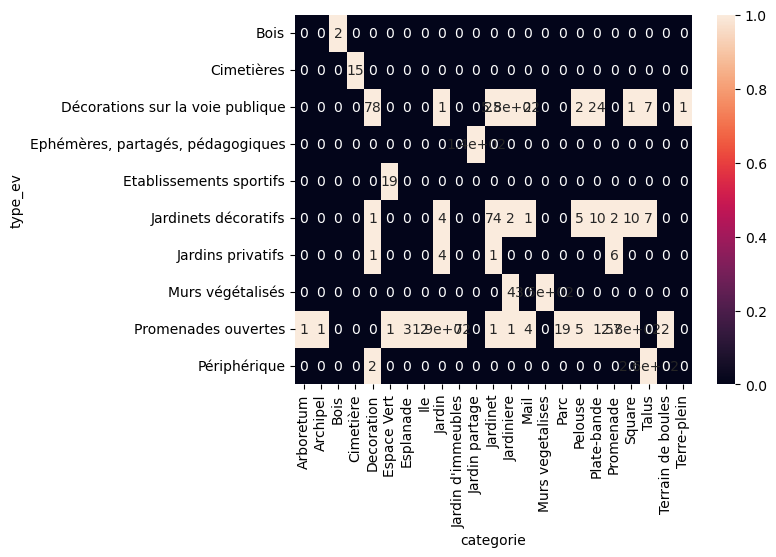

In [35]:
#affichage d'une heatmap tq 0 => une couleur et <1 une autre couleur
sns.heatmap(cross_tab_prop, annot=True, vmax=1)
plt.show()

D'après la heatmap : 
- Les *décorations sur la voie publique* et les *murs végétabilisés* ne représentent pas les espaces verts mais seulement les décorations => suppression de ces catégories
- on remarque que la typologie d'espace vert *Périphérique* ne représente que des décorations vertes (i.e. Talus et Decoration) => suppression de cette catégorie

De plus : 
- Les espaces verts de la typologie *établissements scolaires*, *établissements sportifs* sont des informations répétitives avec celle du dataset DVF => suppression de ces catégories

In [36]:
mask = df_parc["type_ev"].isin(['Promenades ouvertes','Ephémères, partagés, pédagogiques',
    'Jardinets décoratifs','Cimetières','Jardins privatifs' ,'Bois'])
df_parc=df_parc.loc[mask].copy().reset_index(drop=True)
df_parc

,nsq_espace_,nom_ev,type_ev,categorie,adresse_num,adresse_com,adresse_typ,adresse_lib,adresse_cod,poly_area,...,nb_entites,ouvert_ferm,id_division,id_atelier_,ida3d_enb,site_villes,id_eqpt,competence,url_plan,geometry
0,534.0,SQUARE JEHAN RICTUS,Promenades ouvertes,Square,1.0,None,RUE,LA VIEUVILLE,75018,1306.0,...,1.0,Non,118.0,37.0,62667,1871,3623,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.33883 48.88476, 2.33883 48.88476, ..."
1,177.0,PARC DE BERCY,Promenades ouvertes,Parc,2.0,None,RUE,JOSEPH KESSEL,75012,94983.0,...,1.0,Non,111.0,14.0,50023 106262,766,4989,CP,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"MULTIPOLYGON (((2.38075 48.83796, 2.38080 48.8..."
2,865.0,SQUARE JEAN MORIN,Promenades ouvertes,Square,238.0,BIS,RUE DE,CHARENTON,75012,2292.0,...,1.0,Oui,111.0,15.0,49683,3890,3621,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.38887 48.83885, 2.38910 48.83887, ..."
3,947.0,CIMETIERE DE CHARONNE,Cimetières,Cimetière,119.0,None,RUE DE,BAGNOLET,75020,4298.0,...,1.0,Non,15.0,158.0,69780,327,5082,CP,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.40315 48.86046, 2.40313 48.86047, ..."
4,529.0,SQUARE NADAR,Promenades ouvertes,Square,2.0,None,RUE,SAINT ELEUTHERE,75018,1115.0,...,1.0,Oui,118.0,37.0,63113,4149,5023,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.34152 48.88607, 2.34217 48.88594, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,113.0,JARDIN DE LA MAIRIE DU IXEME,Promenades ouvertes,Jardin,6.0,None,RUE,DROUOT,75009,497.0,...,1.0,Non,104.0,8.0,46626,2160,3741,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.34165 48.87259, 2.34172 48.87258, ..."
862,172.0,JARDIN MARGUERITE HURE,Promenades ouvertes,Jardin d'immeubles,2.0,None,BOULEVARD,CARNOT,75012,1818.0,...,1.0,Oui,111.0,16.0,50626,1352,4987,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"MULTIPOLYGON (((2.41316 48.84543, 2.41314 48.8..."
863,362.0,JARDIN DU 62 AU 68 RUE D'ALLERAY,Promenades ouvertes,Jardin,62.0,None,RUE D,ALLERAY,75015,3075.0,...,1.0,Non,115.0,24.0,55900,900,3382,CA,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.30548 48.83633, 2.30543 48.83633, ..."
864,11329.0,PELOUSE DE SAINT CLOUD,Promenades ouvertes,Pelouse,39.0,None,AVENUE DE,SAINT CLOUD,75016,34503.0,...,1.0,None,8.0,55.0,58966,3708,8006,CP,http://p70-planet.apps.paris.mdp/Advitium/Appe...,"POLYGON ((2.25291 48.85648, 2.25290 48.85650, ..."


#### Récupération de la latitude et de la longitude

In [37]:
df_parc['geometry'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Les élements de la colonne 'geometrie' sont des objets géométriques (comme des polygones). 
Nous allons prendre la latitude et la longitude des centroids de ces objets géométriques pour les colonnes latitude et longitude.

In [38]:
df_parc.insert(0,'Groupe','Parc') #ajout de la colonne groupe (qui décrit la catégorie)

#réccupération de la latitude et la longitue des centroids
# conversion du système ESPG 4326 au système EPSG 3857 (système projeté) pour les calculs de centroids 
# puis nouvelle conversion en ESPG 4326 pour bien avoir la latitude et longitude
df_parc['Longitude'] = df_parc['geometry'].to_crs(3857).centroid.to_crs(4326).x #longitude
df_parc['Latitude'] = df_parc['geometry'].to_crs(3857).centroid.to_crs(4326).y #latitude

#création du dataset 
df_parc=df_parc[['Groupe','Longitude','Latitude']].copy() #on récuppère seulement les features qui nous intéresse
df_parc

,Groupe,Longitude,Latitude
0,Parc,2.338695,48.884862
1,Parc,2.381853,48.835638
2,Parc,2.388915,48.838677
3,Parc,2.403676,48.860715
4,Parc,2.341867,48.885924
...,...,...,...
861,Parc,2.341675,48.872412
862,Parc,2.413105,48.845854
863,Parc,2.304980,48.836047
864,Parc,2.254408,48.856397


### e) Fusion de tous les datasets
- Fusion des 4 datasets permettant des définirs les équipements à Paris

In [39]:
df_equip=pd.concat([df_equip,df_monuments,df_parc,df_metro]).copy()
df_equip.reset_index(drop=True,inplace=True)
df_equip

,Groupe,Latitude,Longitude
0,Commerce,48.864008,2.336066
1,Commerce,48.861428,2.347298
2,Commerce,48.865623,2.330458
3,Restaurant,48.861287,2.344954
4,Commerce,48.85779,2.346233
...,...,...,...
67560,Métro,48.87842297018344,2.3816329214594845
67561,Métro,48.84695722895351,2.2950459810371466
67562,Métro,48.853574562874215,2.3339478107981932
67563,Métro,48.83943400710489,2.3961486284893696


In [40]:
df_equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67565 entries, 0 to 67564
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Groupe     67565 non-null  object
 1   Latitude   67565 non-null  object
 2   Longitude  67565 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


Conversion des colonnes latitude et longitude au bon type

In [41]:
df_equip['Latitude']=df_equip['Latitude'].astype(float)
df_equip['Longitude']=df_equip['Longitude'].astype(float)
df_equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67565 entries, 0 to 67564
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Groupe     67565 non-null  object 
 1   Latitude   67565 non-null  float64
 2   Longitude  67565 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB


## 3. Ajout du quartier aux biens immobiliers

L'objectif de cette partie est de **créer le dataset final** i.e. les biens immobiliers avec des features de caractérisations du quartier.
Les données de description du quartier sont le nombre de X dans un périmètre de 500m autout du bien immobiliers. X étant une valeur de la colonne Groupe (ex: métro, commerces alimentaires...).

Une colonne par valeur de la colonne groupe du Dataset final des équipements de Paris est ajouté au dataset du biens. 
Ainsi pour une bien (i.e. une ligne), nous avons : 
| Date-de-muation | valeur_fonciere |... | Commerce |Métro | Parc | .... |
| --------------- |---------------| -----| --- | ---| --- | --- |
| 2020-01-02  | 268800.0 |  ...| 7| 3 | 0 | ...|

In [42]:
#dataset 2020
#creation d'une copie pour travailler dessus 
df=df_appart.copy()

#affichage des 5 premières lignes 
df.head()

,Groupe,Latitude,Longitude,LAT2_rad,LON2_rad
0,Commerce,48.864008,2.336066,0.852838,0.040772
1,Commerce,48.861428,2.347298,0.852793,0.040968
2,Commerce,48.865623,2.330458,0.852866,0.040674
3,Restaurant,48.861287,2.344954,0.852790,0.040927
4,Commerce,48.857790,2.346233,0.852729,0.040949
...,...,...,...,...,...
67560,Métro,48.878423,2.381633,0.853089,0.041567
67561,Métro,48.846957,2.295046,0.852540,0.040056
67562,Métro,48.853575,2.333948,0.852656,0.040735
67563,Métro,48.839434,2.396149,0.852409,0.041821


In [48]:
#affiches des valeurs de la colonne Groupe
equip=df_equip['Groupe'].unique()
equip

array(['Commerce', 'Restaurant', 'Agence immobilière', 'Boulangerie',
       'Banque', 'Commerce alimentaire', 'Piscine', 'Salle de sport',
       'Equipements sportifs extérieurs', 'Divertissement Culturelle',
       'Médecine spécialisée', 'Généraliste', 'Primaire', 'Collège',
       'Maternelle', 'Enseignement supérieur', 'Lycée', 'Crèche', 'Poste',
       'Pharmacie', 'Urgences', 'Monument', 'Parc', 'Métro'], dtype=object)

In [44]:
"""
Fonction qui calcule le nombre d'équipement d'un groupe pour chaque bien grâce à la distance Haversine
-------
Input :
- df_appart - Dataframe des appartements
- df_features - Dataframe des équipements du groupe 
- Distance - float, distance choisie pour la définition du périmètre 
Output: 
- listes du nombre d'équipement du groupe dans le périmètre de l'appartement
"""
def count_object (df_appart,df_feature,distance ) : 
    compteur_feature = []
    for i in range(len(df_appart)) :
        lat_appart = df_appart.at[i,'LAT1_rad']
        lon_appart = df_appart.at[i, "LON1_rad"]
        df_feature['dLON'] = df_feature.loc[:,'LON2_rad'] - lon_appart
        df_feature['dLAT'] = df_feature.loc[:,'LAT2_rad'] - lat_appart
        df_feature['distance'] =  6372.8 *2 * np.arcsin(np.sqrt(np.sin(df_feature.loc[:,'dLAT']/2)**2 + math.cos(lat_appart) * np.cos(df_feature.loc[:,'LAT2_rad']) * np.sin(df_feature.loc[:,'dLON']/2)**2))
        df_feature['compte'] = np.where(df_feature.loc[:,'distance']<distance, 1, 0) 
        compteur_feature.append (df_feature['compte'].sum())
    return compteur_feature

In [45]:
"""
Fonction qui crée le Dataset final i.e. ajoute les colonnes descriptives du quarties à celui des appartements 
---
Input : 
- df - Dataframe des appartements
- df_equip - Dataframe globale de toutes les catégories de groupe
"""
def equipement(df,df_equip):
    equip=df_equip.loc[:,'Groupe'].unique().tolist()

    #ajout des colonnes LAtitude/longitude en radians utiles pour le cacul de la distance de Haversine

    #au dataset des biens immobiliers
    df['LAT1_rad'] = np.radians(df['latitude'])
    df['LON1_rad'] = np.radians(df['longitude'])

    #au dataset équipements
    df_equip['LAT2_rad'] = np.radians(df_equip['Latitude'])
    df_equip['LON2_rad'] = np.radians(df_equip['Longitude'])

    #boucle sur les catégories de groupe d'équipement
    for e in equip:
        print(e)
        df_features=df_equip.loc[df_equip['Groupe']==str(e)].copy()
        df_features.reset_index(inplace=True,drop=True)
        compteur=count_object(df,df_features,0.5)
        df[str(e)]=compteur
    return df

In [46]:
df

,date_mutation,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,LAT1_rad,LON1_rad
0,2020-01-02,268800.0,75008,24.0,1,2.323937,48.871607,0.852970,0.040560
1,2020-01-06,878378.0,75001,66.0,2,2.326882,48.869331,0.852931,0.040612
2,2020-01-10,680000.0,75003,51.0,2,2.351965,48.864157,0.852840,0.041050
3,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017,0.852803,0.041246
4,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017,0.852803,0.041246
...,...,...,...,...,...,...,...,...,...
34237,2020-12-16,1937500.0,75004,37.0,2,2.350486,48.854301,0.852668,0.041024
34238,2020-12-16,1937500.0,75004,46.0,2,2.350486,48.854301,0.852668,0.041024
34239,2020-12-16,1937500.0,75004,32.0,2,2.350486,48.854301,0.852668,0.041024
34240,2020-12-16,1937500.0,75004,22.0,1,2.350486,48.854301,0.852668,0.041024


In [47]:
df_final=equipement(df,df_equip)
df_final.drop(columns=['LAT1_rad','LON1_rad'],inplace=True) #suppresion des colonnes inutiles 
df_final.to_csv('data/dataframe_final.csv') #enregistrement du dataset final
df_final

Commerce
Restaurant
Agence immobilière
Boulangerie
Banque
Commerce alimentaire
Piscine
Salle de sport
Equipements sportifs extérieurs
Divertissement Culturelle
Médecine spécialisée
Généraliste
Primaire
Collège
Maternelle
Enseignement supérieur
Lycée
Crèche
Poste
Pharmacie
Urgences
Monument
Parc
Métro


,date_mutation,valeur_fonciere,code_postal,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,Commerce,Restaurant,Agence immobilière,...,Maternelle,Enseignement supérieur,Lycée,Crèche,Poste,Pharmacie,Urgences,Monument,Parc,Métro
0,2020-01-02,268800.0,75008,24.0,1,2.323937,48.871607,580,265,151,...,1,2,4,5,4,8,0,0,1,18
1,2020-01-06,878378.0,75001,66.0,2,2.326882,48.869331,696,264,139,...,0,3,2,1,2,11,0,1,0,22
2,2020-01-10,680000.0,75003,51.0,2,2.351965,48.864157,574,530,148,...,2,8,1,9,2,16,0,2,8,12
3,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017,485,270,113,...,3,9,2,8,2,10,0,0,11,7
4,2020-01-03,852000.0,75003,12.0,1,2.363196,48.862017,485,270,113,...,3,9,2,8,2,10,0,0,11,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34237,2020-12-16,1937500.0,75004,37.0,2,2.350486,48.854301,223,278,44,...,0,5,0,8,1,9,1,7,15,13
34238,2020-12-16,1937500.0,75004,46.0,2,2.350486,48.854301,223,278,44,...,0,5,0,8,1,9,1,7,15,13
34239,2020-12-16,1937500.0,75004,32.0,2,2.350486,48.854301,223,278,44,...,0,5,0,8,1,9,1,7,15,13
34240,2020-12-16,1937500.0,75004,22.0,1,2.350486,48.854301,223,278,44,...,0,5,0,8,1,9,1,7,15,13
